<a href="https://colab.research.google.com/github/gabbycjames/DataScience_Capstone/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Desert Investigation -- Modeling

## Imports

In [91]:
import os
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
#%matplotlib inline

In [92]:
import time
import warnings
from itertools import cycle, islice

import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

import sklearn.decomposition
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.colors
%matplotlib inline
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

In [94]:
#sklearn.show_versions()

## Data

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
df = pd.read_csv('/content/drive/MyDrive/DataScience_Capstone/scaled_data.csv')

In [97]:
df.head()

,FIPS,CACFP_PART_2016,CONVS16,FFR16,FSR16,GROC16,NSLP_PART_2016,PCT_WICINFANTCHILD16,PCT_WICWOMEN16,RECFAC16,...,Asian,Latino,HS_GED,Bachelors,Employed,Unemployed,Midwest,Northeast,South,West
0,-1.939205,-0.45354,-0.096774,-0.118123,-0.176332,-0.197530,-0.398,1.35391,0.898924,-0.130226,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414
1,-1.939073,-0.45354,0.799750,0.298354,0.582731,0.090641,-0.398,1.35391,0.898924,0.275224,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414
2,-1.938941,-0.45354,-0.220432,-0.196213,-0.239279,-0.186447,-0.398,1.35391,0.898924,-0.292406,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414
3,-1.938809,-0.45354,-0.261652,-0.255709,-0.265198,-0.175363,-0.398,1.35391,0.898924,-0.265376,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414
4,-1.938677,-0.45354,-0.137993,-0.196213,-0.246684,-0.175363,-0.398,1.35391,0.898924,-0.184286,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414


## K-Means

### Choosing Number of Clusters
**Elbow Method**

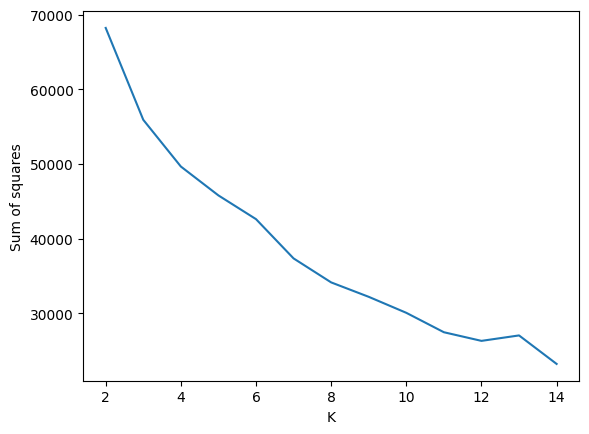

In [98]:
ss = []
possible_k = {}
Krange = list(range(2,15))
X = df.to_numpy()

for i in Krange:
    model = KMeans(n_clusters=i)
    current_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[current_cluster])**2))
    possible_k[str(i)] = current_cluster

plt.plot(Krange,ss)
plt.xlabel("K")
plt.ylabel("Sum of squares")
plt.show()


**Choosing K:** By using the elbow method, it looks like 8 is a good value for K. My goal is to minimize the sum of squares, without getting too large of a value for K.

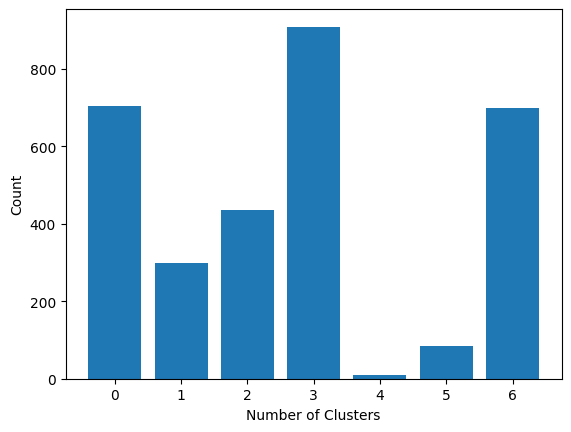

In [99]:
K = 7
best_K = possible_k[str(K)]
count = np.bincount(best_K)
_ = plt.bar(range(K), height=count, align='center')
_ = plt.xlabel('Number of Clusters')
_ = plt.ylabel('Count')
_ = plt.show()

**Silhouette Scores**

For n_clusters =  2 the average silhouette score is:  0.5502071821596443
For n_clusters =  3 the average silhouette score is:  0.5358776474190535
For n_clusters =  4 the average silhouette score is:  0.22671248578456898
For n_clusters =  5 the average silhouette score is:  0.2587423116110895
For n_clusters =  6 the average silhouette score is:  0.2858940107804763
For n_clusters =  7 the average silhouette score is:  0.30094706928104503
For n_clusters =  8 the average silhouette score is:  0.3182067455423621
For n_clusters =  9 the average silhouette score is:  0.31405678430746187
For n_clusters =  10 the average silhouette score is:  0.32300702034498324
For n_clusters =  11 the average silhouette score is:  0.32006717176581756
For n_clusters =  12 the average silhouette score is:  0.35487272829144406
For n_clusters =  13 the average silhouette score is:  0.3761339036734593
For n_clusters =  14 the average silhouette score is:  0.35362712492149


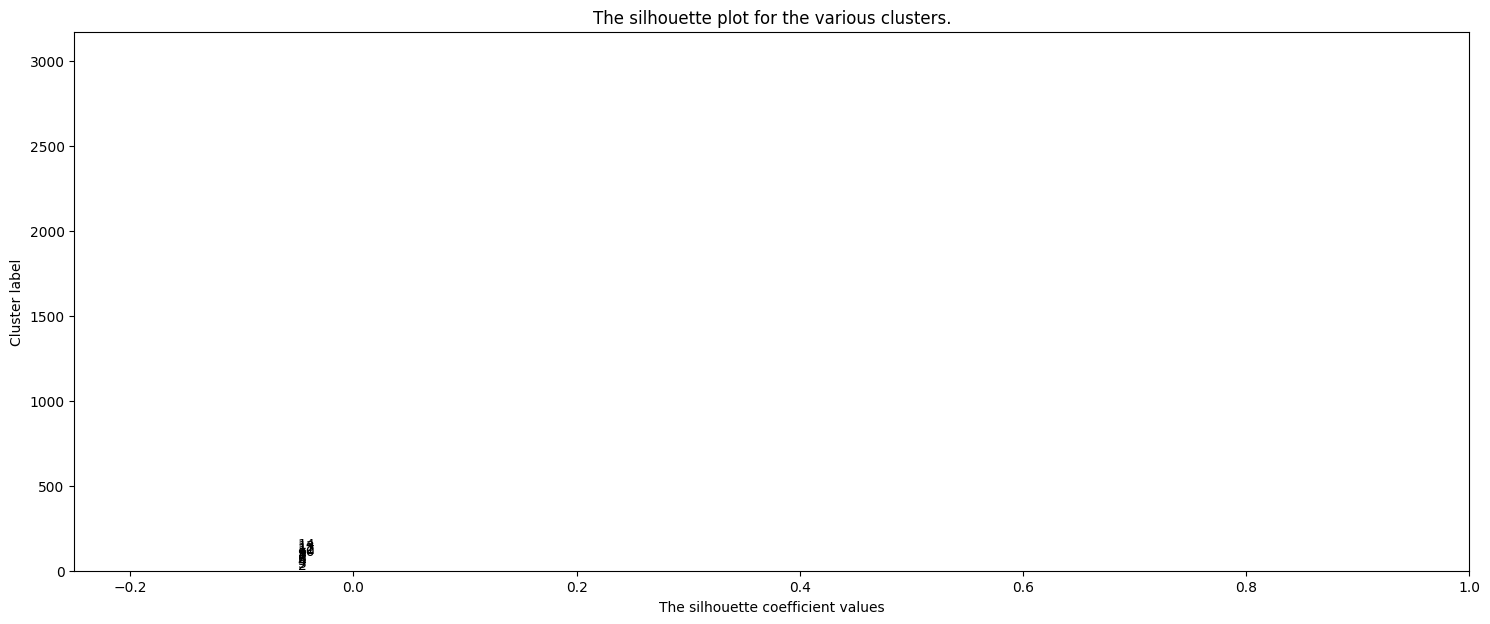

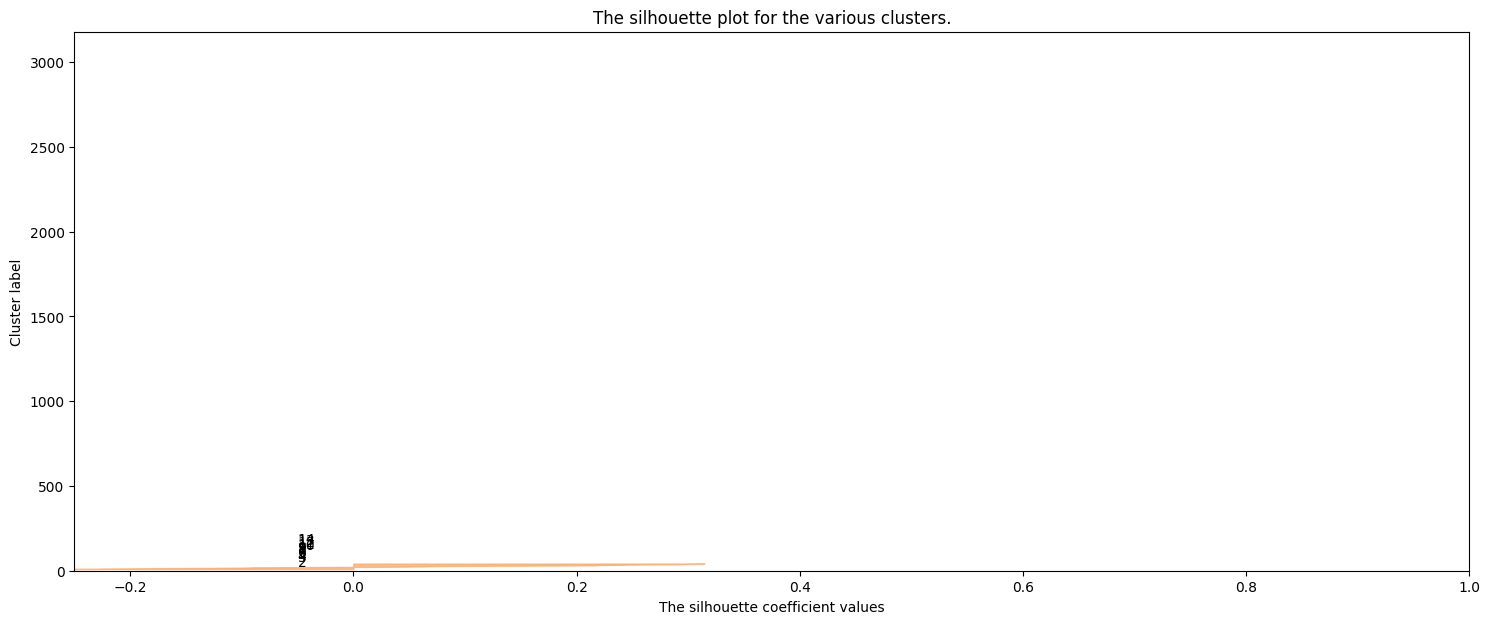

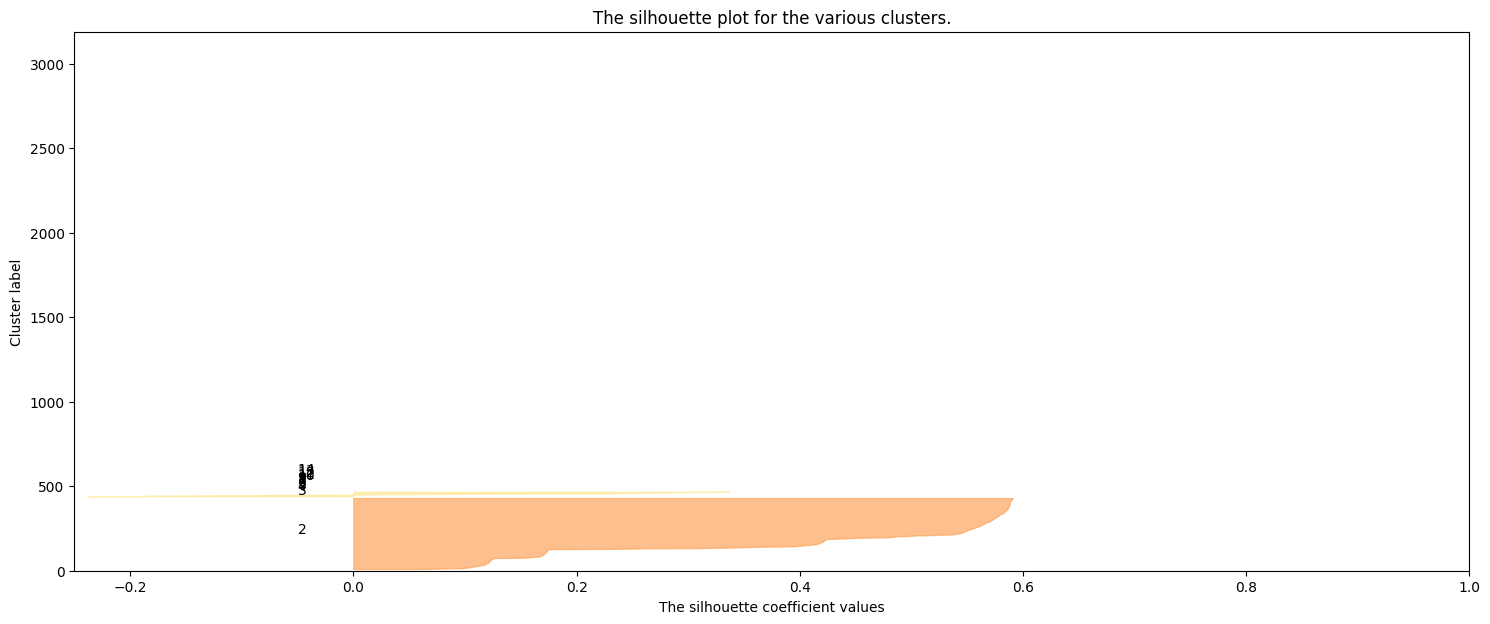

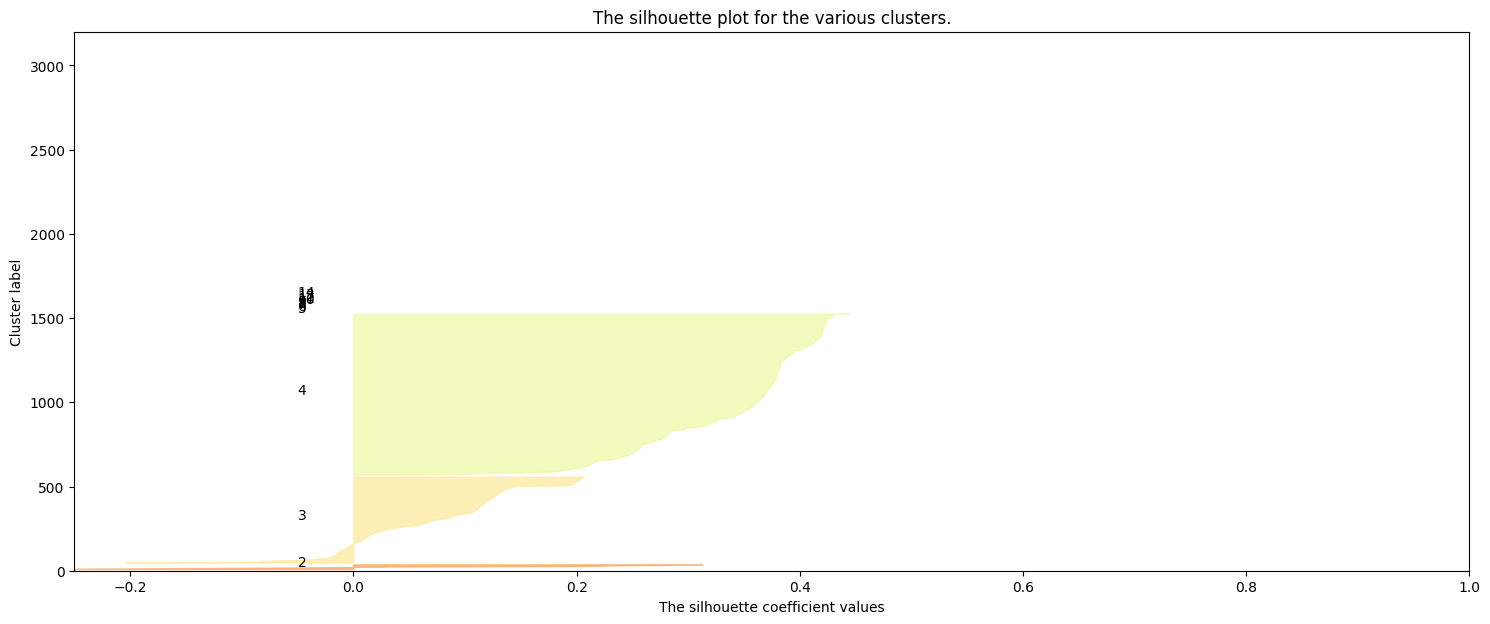

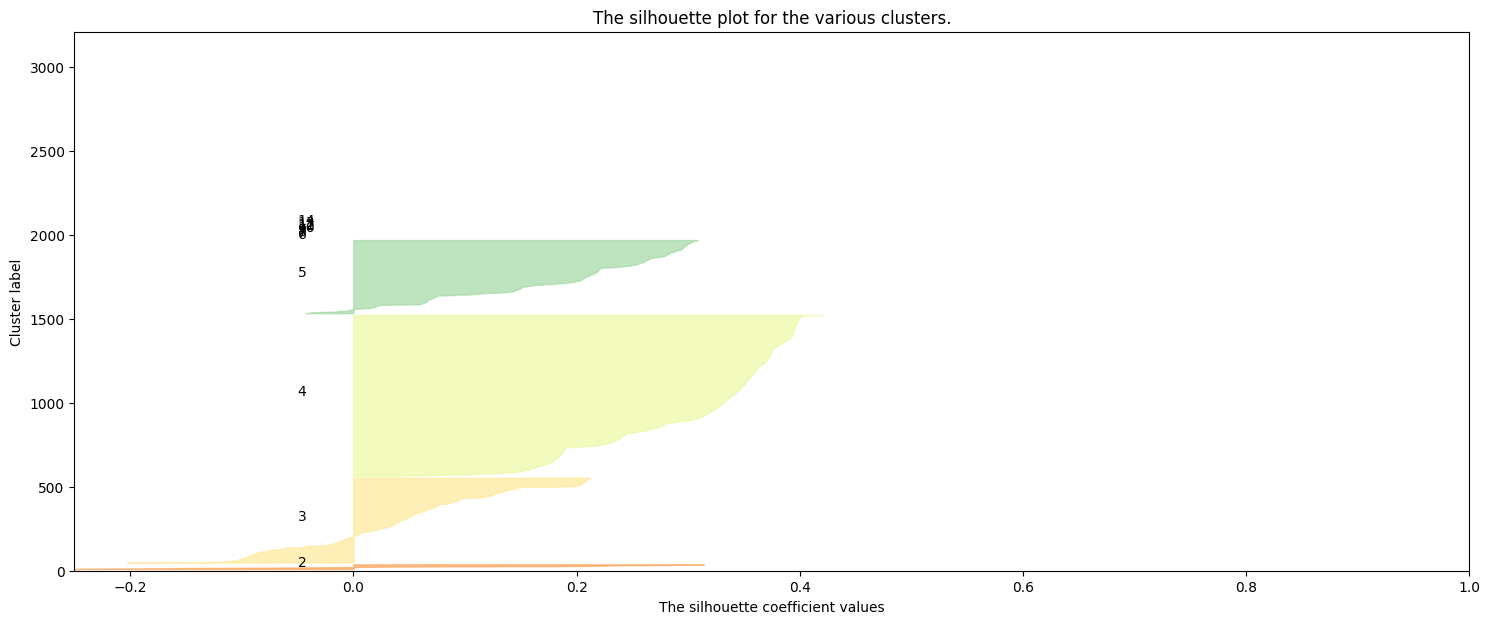

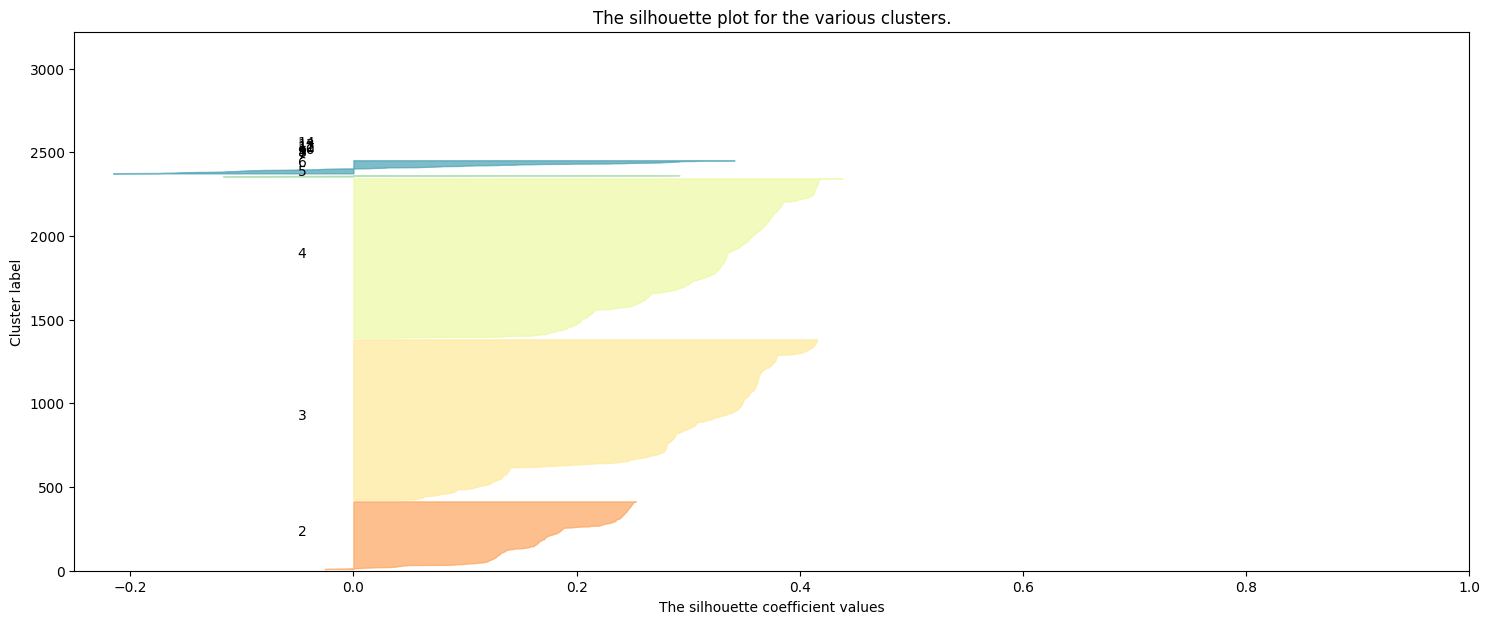

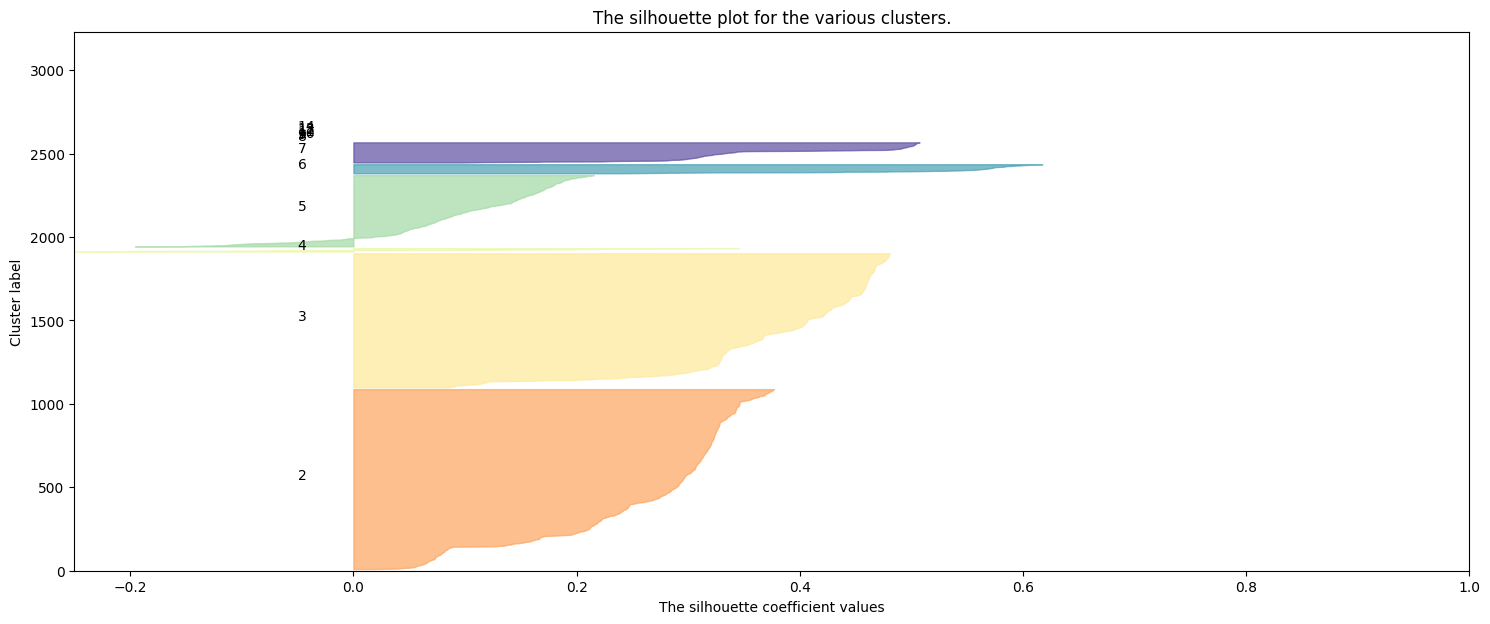

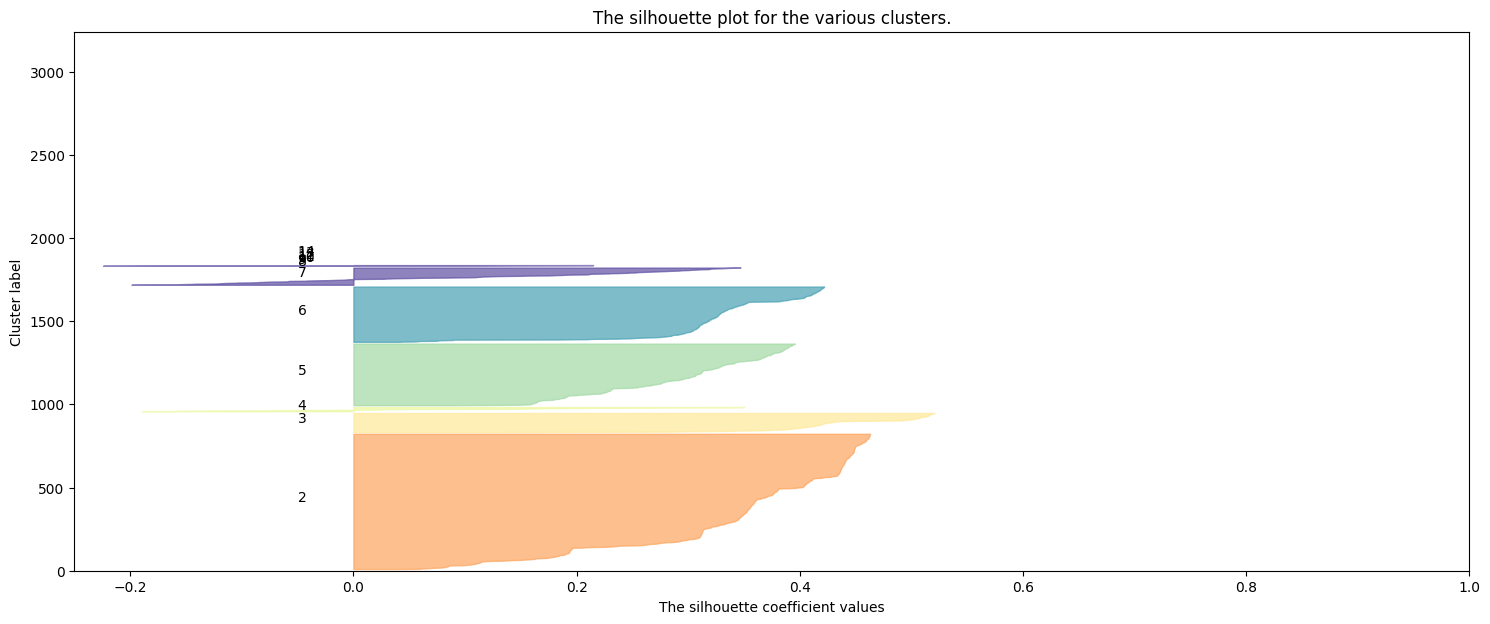

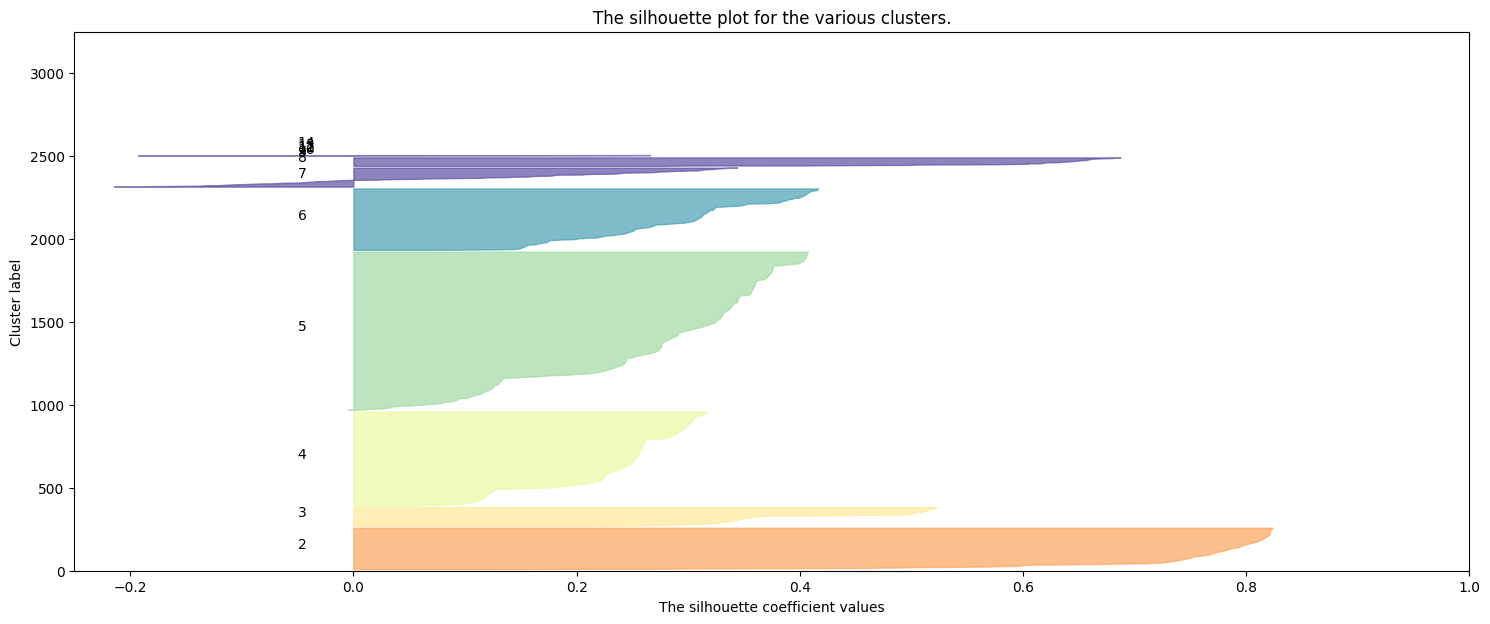

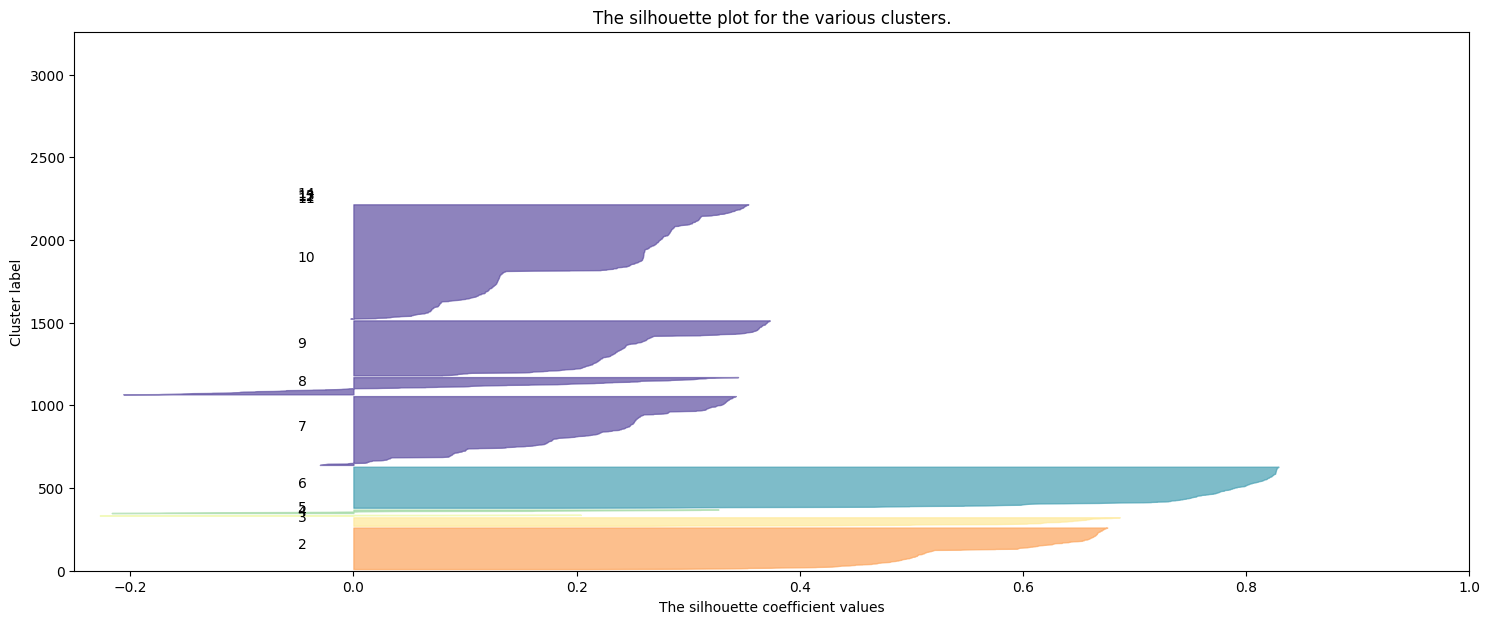

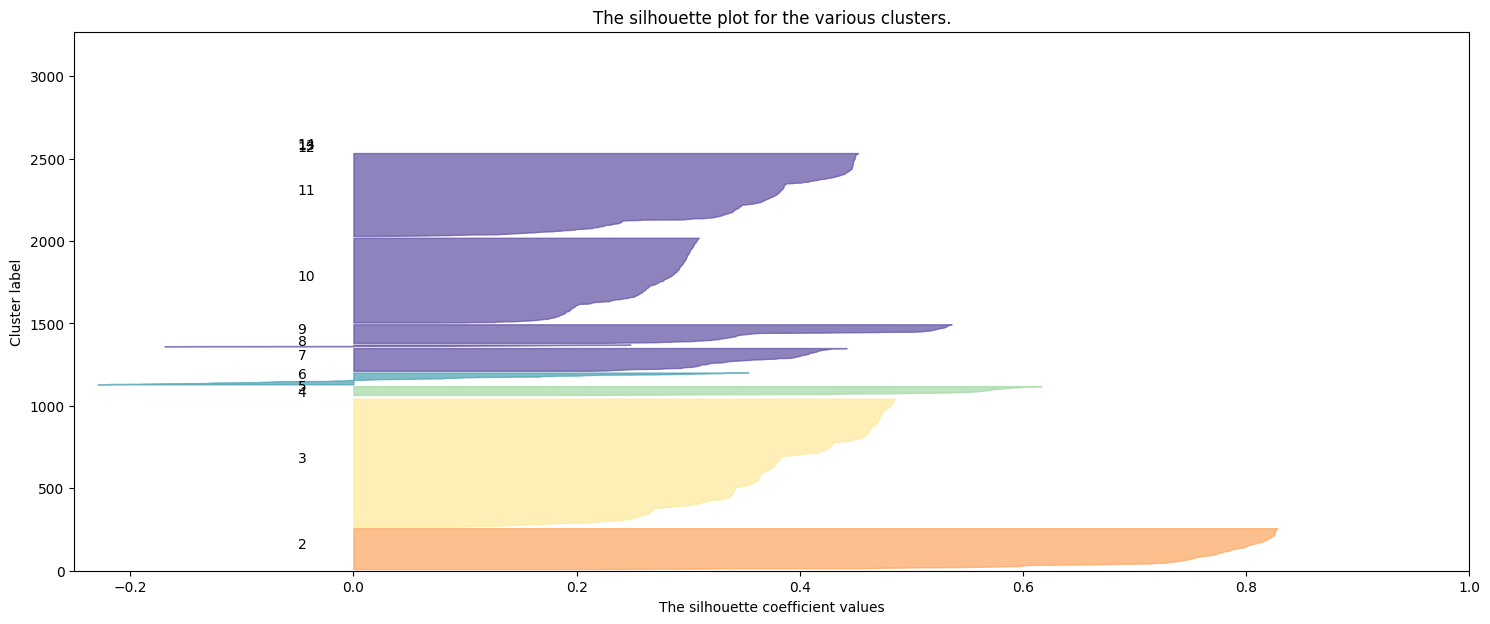

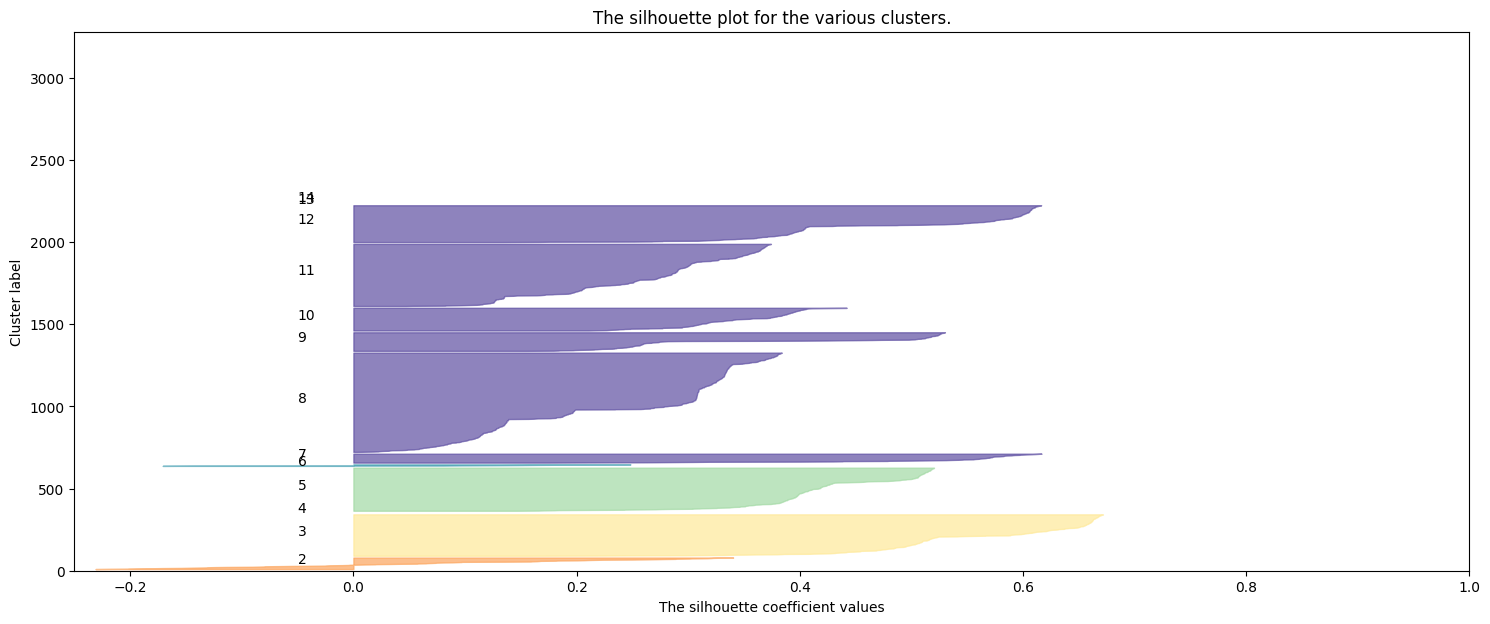

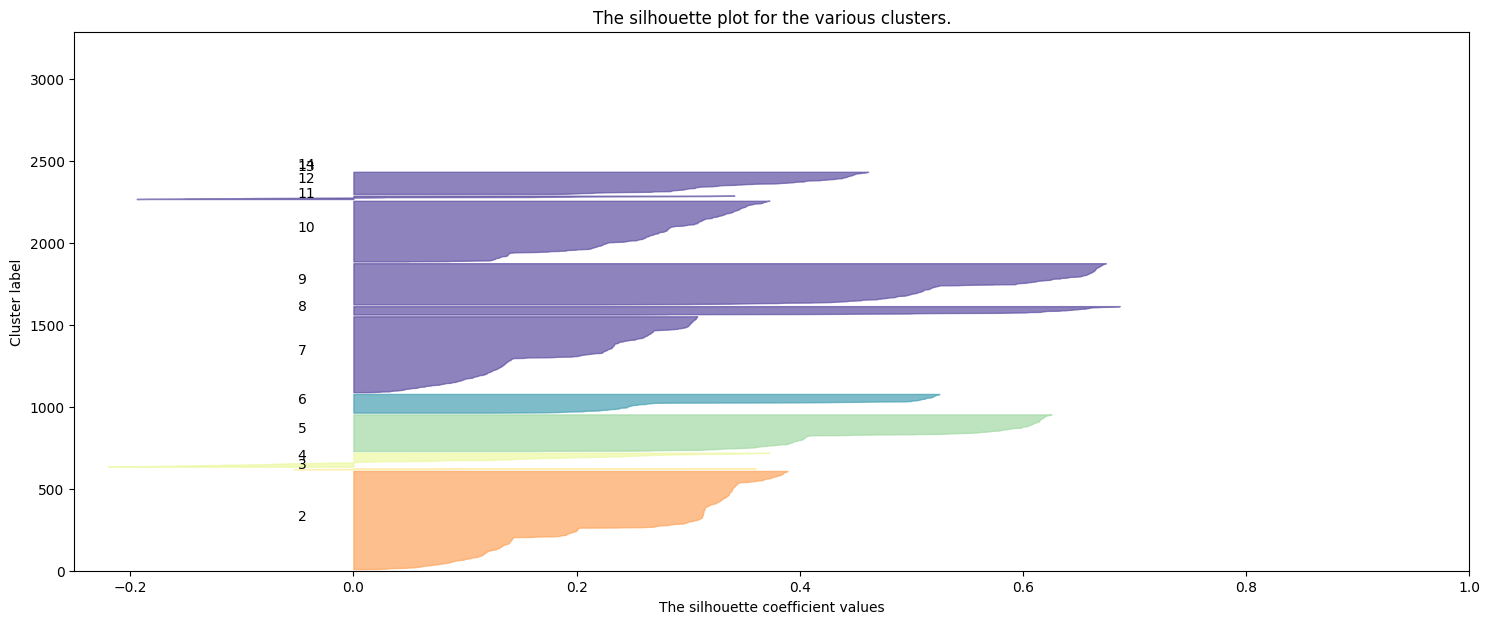

In [100]:
avg_silhouette_scores = []

for n_clusters in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.25, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in Krange:
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        y_upper = y_lower + size_cluster_i


        cmap = mpl.colormaps.get_cmap("Spectral")
        color = cmap(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")


    print("For n_clusters = ", n_clusters, "the average silhouette score is: ", silhouette_avg)

In [101]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
klabels = kmeans.labels_

In [102]:
kmeans_silhouette = silhouette_score(X, klabels)

print(f'Silhouette Score: {kmeans_silhouette}')

Silhouette Score: 0.25962043719869676


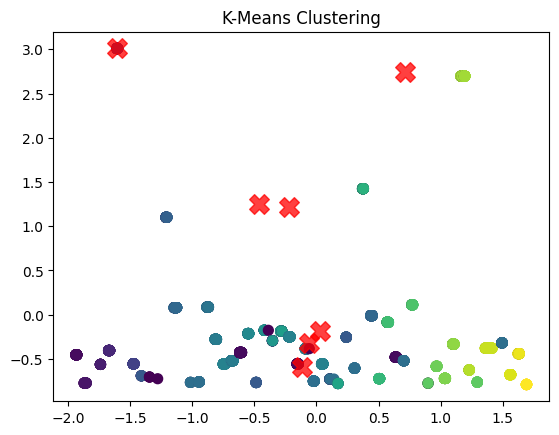

In [103]:
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

# Mark the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='X')

plt.title('K-Means Clustering')
plt.show()

## Affinity Propagation

**Affinity Propagation**

In [104]:
affinity = AffinityPropagation(random_state=42)
affinity.fit(X)
affinity_labels= affinity.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



In [105]:
cluster_centers_indices = affinity.cluster_centers_indices_

n_clusters_ = len(cluster_centers_indices)

**Silhouette Coefficient**

In [106]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Silhouette Coefficient: 0.584


In [107]:
affinity_silhouette = silhouette_score(X, affinity_labels)

print(f'Silhouette Score: {affinity_silhouette}')

Silhouette Score: 0.4174666161103535


**Cluster Results**

In [108]:
print("Number of clusters detected by Affinity Propagation: ", n_clusters_)

Number of clusters detected by Affinity Propagation:  443


In [109]:
print("Cluster centers detected at: \n\n", X[cluster_centers_indices])

Cluster centers detected at: 

 [[-1.93709338 -0.45353994  0.04749431 ... -0.27246797  1.09916219
  -0.40741366]
 [-1.86470305 -0.77292992 -0.38531041 ... -0.27246797 -0.90978384
   2.45450779]
 [-1.74044509 -0.5623304   9.57950314 ... -0.27246797 -0.90978384
   2.45450779]
 ...
 [ 1.6244843  -0.44039807 -0.17921292 ... -0.27246797 -0.90978384
  -0.40741366]
 [ 1.62936751 -0.44039807  3.04621277 ... -0.27246797 -0.90978384
  -0.40741366]
 [ 1.6920574  -0.789131   -0.28226167 ... -0.27246797 -0.90978384
   2.45450779]]


**Visualization**

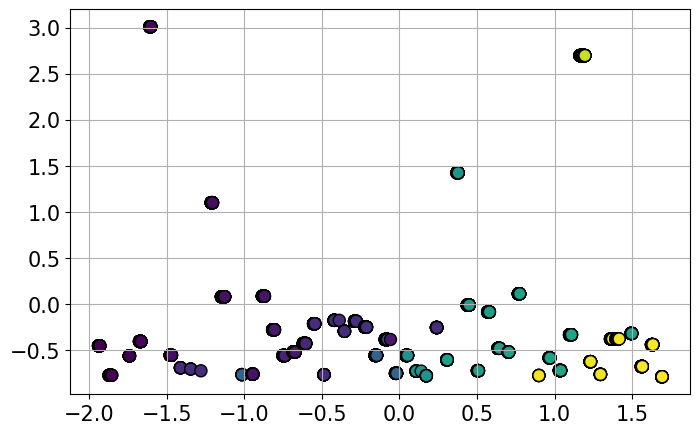

In [110]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],edgecolors='k',c=affinity.labels_,s=75)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Spectral Clustering
**Modeling**

In [111]:
spectral = SpectralClustering(n_clusters=15, random_state=42)
spectral.fit(X)
spectral_labels = spectral.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (15). Possibly due to duplicate points in X.



**Silhouette Coefficient**

In [112]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, spectral_labels, metric='sqeuclidean'))

Silhouette Coefficient: 0.966


In [113]:
spectral_silhouette = silhouette_score(X, spectral_labels)

print(f'Silhouette Score: {spectral_silhouette}')

Silhouette Score: 0.8509256720027829


**Cluster Results**

In [114]:
print("Number of clusters detected by Spectral Clustering: ", n_clusters_)

Number of clusters detected by Spectral Clustering:  443


**Visualization**

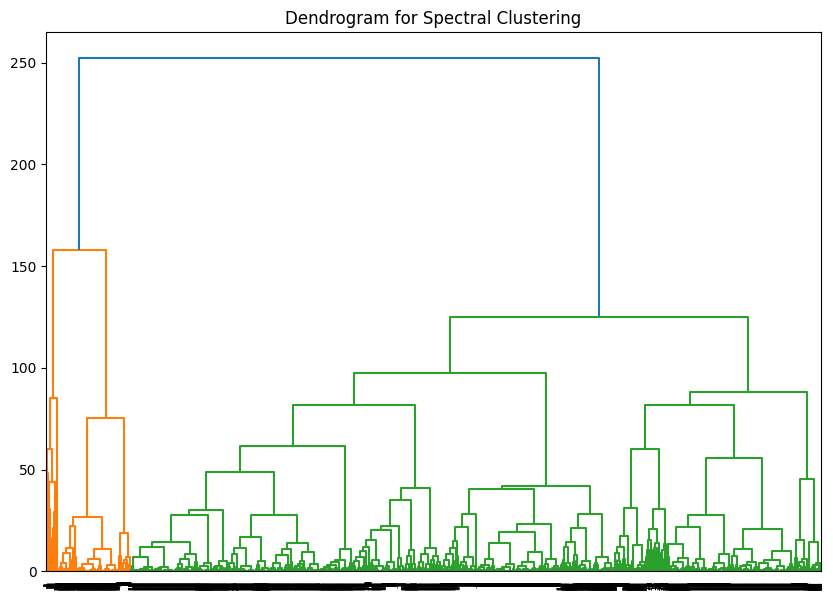

In [115]:
linked = linkage(X, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=labels, distance_sort='descending', show_leaf_counts=True)
plt.title("Dendrogram for Spectral Clustering")
plt.show()

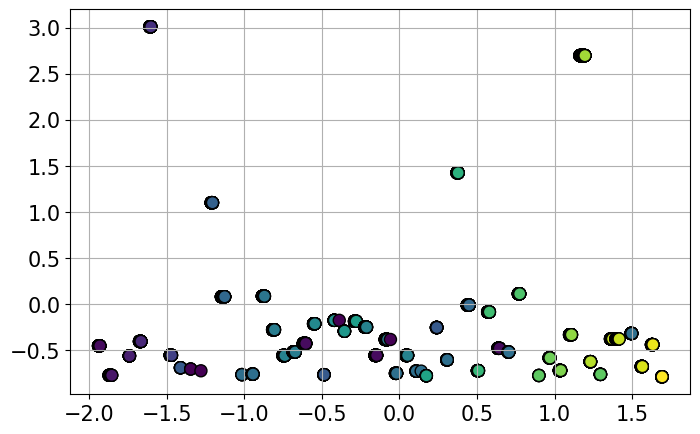

In [116]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1],edgecolors='k',c=labels,s=75)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

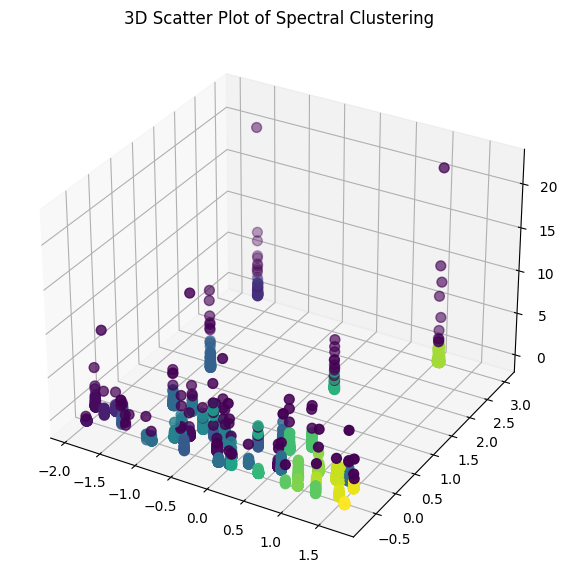

In [117]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='viridis', s=50)
ax.set_title("3D Scatter Plot of Spectral Clustering")
plt.show()

## Agglomerative Clustering

**Model**

In [118]:
agglo = AgglomerativeClustering(distance_threshold=1.0,n_clusters=None)
agglo.fit(X)

AgglomerativeClustering(distance_threshold=1.0, n_clusters=None)

In [119]:
agglabels = agglo.labels_

**Silhouette Coefficient**

In [120]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, agglabels, metric='sqeuclidean'))

Silhouette Coefficient: 0.500


In [121]:
agglomerative_silhouette = silhouette_score(X, agglabels)

print(f'Silhouette Score: {agglomerative_silhouette}')

Silhouette Score: 0.3523410653442054


**Visualization**

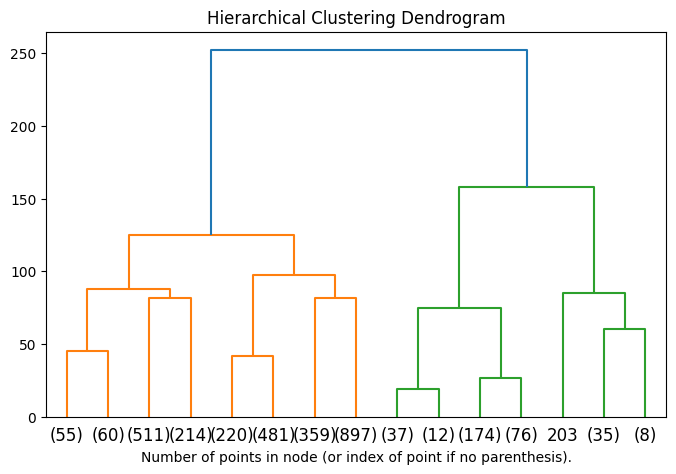

In [122]:
def plot_dendrogram(model, **kwargs):

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(8,5))
plt.title("Hierarchical Clustering Dendrogram")

plot_dendrogram(agglo, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

**Cluster Results:**
Based on the results above, two clusters is the ideal number to use.

In [123]:
agglo2 = AgglomerativeClustering(n_clusters=2)
agglo2.fit(X)

AgglomerativeClustering()

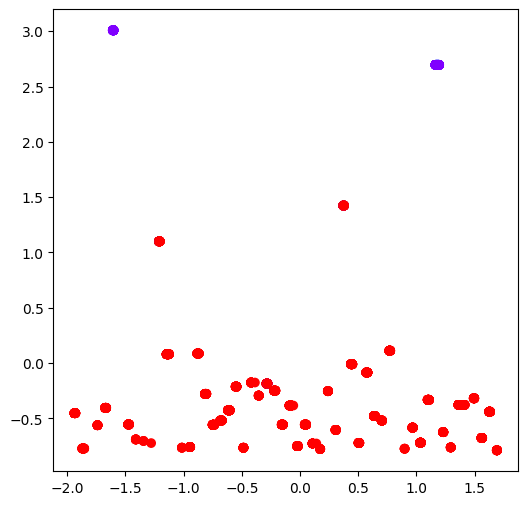

In [124]:
plt.figure(figsize=(6,6))
plt.scatter(X[:,0],X[:,1],c=agglo2.labels_,cmap='rainbow')
plt.show()

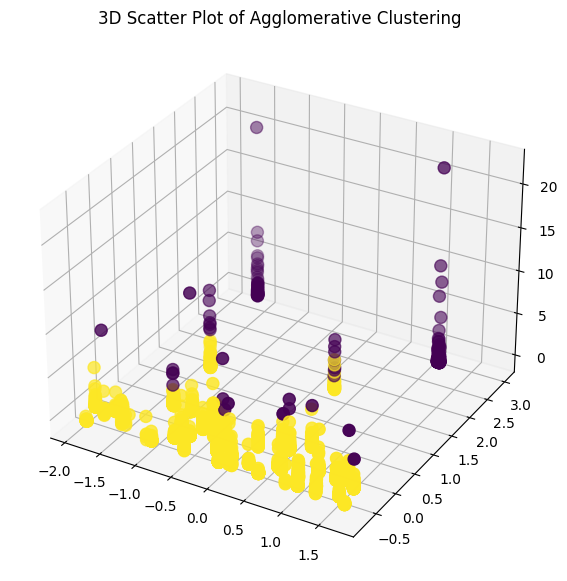

In [125]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=agglo2.labels_, cmap='viridis', s=75)
ax.set_title("3D Scatter Plot of Agglomerative Clustering")
plt.show()


## DBSCAN

**Model**

In [126]:
dbscan = DBSCAN(eps=2, min_samples=3).fit(X)
dbscan.fit(X)
dbscan_labels = dbscan.labels_

In [127]:
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
print(core_samples)
#Calculating "the number of clusters"
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)

[ True  True  True ...  True  True  True]
36


**Silhouette Coefficient**

In [128]:
#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, dbscan_labels))

Silhouette Coefficient: 0.469


In [129]:
dbscan_silhouette = silhouette_score(X, dbscan_labels)

print(f'Silhouette Score: {dbscan_silhouette}')

Silhouette Score: 0.46882936315905754


**Cluster Results**

In [130]:
print("Number of clusters detected by DBSCAN: ", n_clusters_)

Number of clusters detected by DBSCAN:  36


**Visualization**

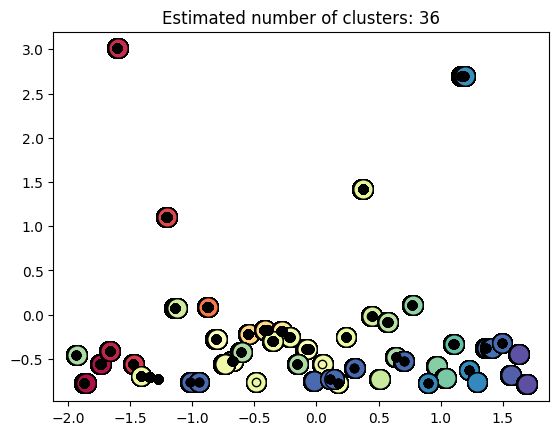

In [131]:
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(labels))]
for k, col in zip(labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

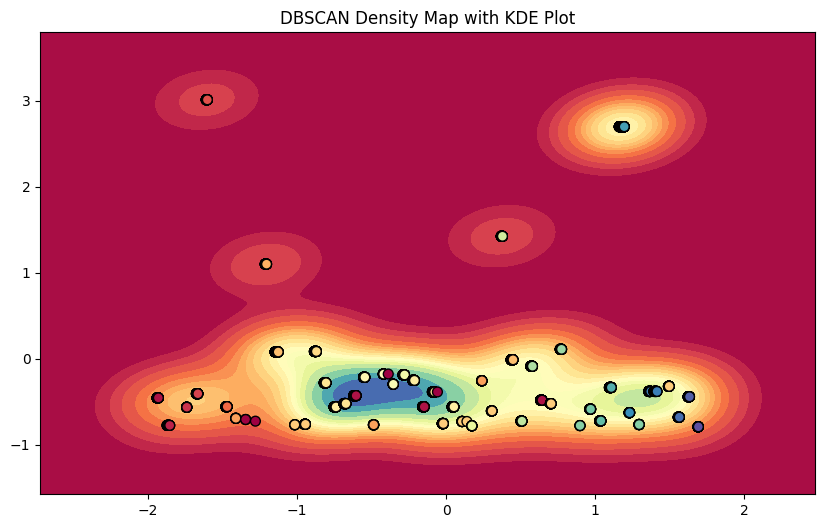

In [132]:
import seaborn as sns

# Assuming 2D data in X
plt.figure(figsize=(10, 6))
sns.kdeplot(x=X[:, 0], y=X[:, 1], fill=True, cmap='Spectral', thresh=0, levels=20)
plt.scatter(X[:, 0], X[:, 1], c=labels, edgecolor='k', cmap='Spectral', s=50)
plt.title("DBSCAN Density Map with KDE Plot")
plt.show()

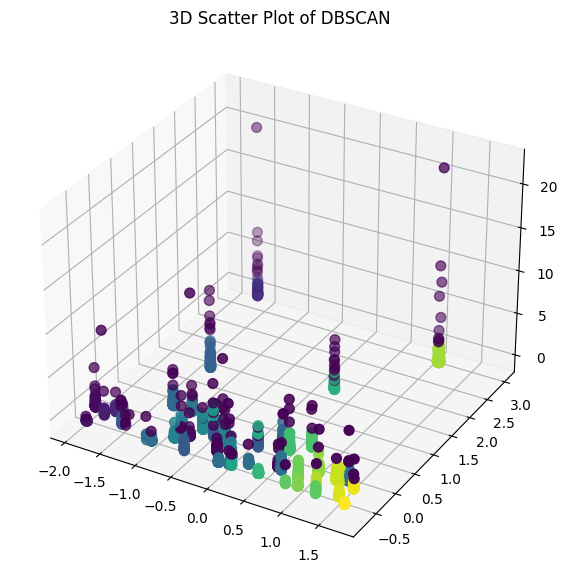

In [133]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='viridis', s=50)
ax.set_title("3D Scatter Plot of DBSCAN")
plt.show()

## Model Metrics Preparation
I am creating a model metrics file as a txt file.

In [141]:
# Create a model metrics text file comparing multiple clustering algorithms
with open('model_metrics.txt', 'w') as file:
    file.write("Model: K-Means\n")
    file.write("Hyperparameters: n_clusters=7, random_state=42\n")
    file.write("Number of Clusters: 7\n")
    file.write(f"Silhouette Score: {kmeans_silhouette:.3f}\n\n")

    file.write("Model: Affinity Propagation\n")
    file.write("Hyperparameters: random_state=42\n")
    file.write(f"Number of Clusters: {len(set(affinity_labels))}\n")
    file.write(f"Silhouette Score: {affinity_silhouette:.3f}\n\n")

    file.write("Model: Spectral Clustering\n")
    file.write("Hyperparameters: n_clusters=15, random_state=42\n")
    file.write("Number of Clusters: 15\n")
    file.write(f"Silhouette Score: {spectral_silhouette:.3f}\n\n")

    file.write("Model: Agglomerative Clustering\n")
    file.write("Hyperparameters: n_clusters=2, distance_threshold=1.0\n")
    file.write("Number of Clusters: 2\n")
    file.write(f"Silhouette Score: {agglomerative_silhouette:.3f}\n\n")

    file.write("Model: DBSCAN\n")
    file.write("Hyperparameters: eps=2, min_samples=3\n")
    file.write(f"Number of Clusters: {len(set(dbscan_labels))}\n")
    file.write(f"Silhouette Score: {dbscan_silhouette}\n")
